### **Dog breed image classification model using ResNet50 CNN architecture**

Import Libraries

In [1]:
import numpy as np
from tensorflow.keras.applications import resnet50
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split
from os.path import join
import pandas as pd

### Load Data

In [2]:
labels = pd.read_csv('labels.csv')
# only keep the unique ids
labels_unique = labels.drop_duplicates(subset=['id'])
labels_unique['breed'] = labels_unique['breed'].astype('category')

### As given in the assignment The classifier should only predict scores for these breeds : beagle, chihuahua, doberman,french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound, tibetan_mastiff

Extract the Working labels

In [3]:
work_labels = labels_unique.loc[labels_unique['breed'].isin(['beagle', 'chihuahua', 'doberman','french_bulldog', 
                                                       'golden_retriever', 'malamute', 'pug', 'saint_bernard', 
                                                       'scottish_deerhound','tibetan_mastiff'])]
work_labels.reset_index(inplace=True,drop = True)

In [4]:
df_num, df_meta = pd.factorize(work_labels['breed'])
work_labels_new = pd.concat([work_labels, pd.DataFrame(df_num,columns=['breedNum'])], axis=1)
work_labels_new.head()

,id,breed,breedNum
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,1
2,008b1271ed1addaccf93783b39deab45,doberman,2
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever,0
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever,0


### readConvertImg() Method will take the path of the image and image size as input and return an 3D array containing scaled values

In [6]:
# This Function will read the image from image path and convert it numpy array
def readConvertImg(path,height,width):
    # load image
    img = load_img(path, target_size=(height, width))
    # convert to array
    img_array = np.array([img_to_array(img)])
    # scale and return
    output = preprocess_input(img_array)
    return(output)

### Read the Data from train_data only on using the ids which are in work_labels

In [7]:
img_size = 224
X = np.zeros((len(work_labels),img_size,img_size,3))
Y = np.zeros(len(work_labels))
k = 0
dire = '../Totalitycorp/train_data/'
for (i,l,t) in zip(work_labels_new['id'],work_labels_new['breedNum'],work_labels_new['breed']):
    file = str(i)+'.jpg'
    pth = join(dire,file)
    X[k] = readConvertImg(pth,img_size,img_size)
    Y[k] = int(l)
    k +=1

In [102]:
import requests
import json
import base64
from io import BytesIO
from PIL import Image

with open('../Totalitycorp/train_data/'+work_labels_new['id'].loc[2]+'.jpg', "rb") as f:
    im_b64 = base64.b64encode(f.read())
data= json.dumps({'image': im_b64.decode('utf-8')})
local = 'http://127.0.0.1:5000/' # change to your app name
temp = 'https://dog-breed-flask-model.herokuapp.com/'


In [103]:
r = requests.post(local,data)
r.json()

{'breed': 'Doberman', 'score': '0.97560227'}

(1, 224, 224, 3)


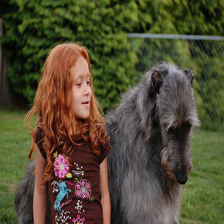

In [99]:
import base64
from io import BytesIO
from PIL import Image

with open('../Totalitycorp/train_data/'+work_labels_new['id'].loc[1]+'.jpg', "rb") as f:
    im_b64 = base64.b64encode(f.read())

im_bytes = base64.b64decode(im_b64)   # im_bytes is a binary image
im_file = BytesIO(im_bytes)  # convert image to file-like object
img = Image.open(im_file)   # img is now PIL Image object
#img.thumbnail(size=(224, 224))
new_img = img.resize(size=(224,224))
img_array = np.array([img_to_array(new_img)])
    # scale and return
output = preprocess_input(img_array)
print(output.shape)
display(new_img)

### Load the Pre-Trained ResNet50 Model

In [7]:
my_model =resnet50.ResNet50(weights = 'imagenet')

### Do prediction on our Data Set

In [8]:
preds = my_model.predict(X)
most_likely_labels = resnet50.decode_predictions(preds,top=1)

### Find Prediction score

In [10]:
Predicted_labels = []
prob = []
for i in range(len(most_likely_labels)):
    # take the predicted labels in the list
    Predicted_labels.append(most_likely_labels[i][0][1])
    prob.append(most_likely_labels[i][0][2])

pred_value = []
for (i,j,n) in zip(Predicted_labels,work_labels_new['breed'],work_labels_new['breedNum']):
    # convert the correct predicted label to 1 and false to 0
    if i.casefold() == j.casefold():
        pred_value.append(n)
    else:
        pred_value.append(-1)

# Calculate Prediction Percentage
pred_arr = np.array(pred_value)
print('Prediction Score is  = ',(len(np.where(pred_arr >= 0)[0])/len(work_labels) )*100)

Prediction Score is  =  77.64565992865636


In [11]:
print(Y[0:5],end = "   ")
print(pred_arr[0:5])

[0. 1. 2. 0. 0.]   [0 1 2 0 0]


### Evalution Matrix

#### Accuracy

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(Y, pred_arr)

0.7764565992865636

#### Confusion Matrix

In [21]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
import itertools

Confusion matrix, without normalization


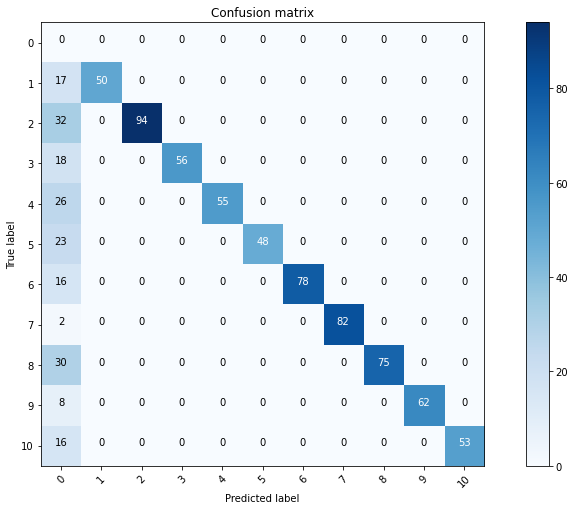

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y, pred_arr)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)

plt.figure(figsize = (12,7))
plot_confusion_matrix(cm, classes=[0, 1,2,3,4,5,6,7,8,9,10],
                      title='Confusion matrix')

#### F1 Score

In [33]:
from sklearn.metrics import f1_score
f1_score(Y, pred_arr,average = None)

array([0.        , 0.83333333, 0.80672269, 0.86153846, 0.93939394,
       0.85470085, 0.80882353, 0.90697674, 0.98795181, 0.85454545,
       0.86885246])